### **Authors**:

1. **Kuba Czech, 156035**
2. **Wojciech Nagórka, 156045**

In [81]:
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import svm
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import PartialDependenceDisplay, permutation_importance

# **0. Introduction**

## **0.1 Define appropriate function and load data** ##

In [82]:
def load_data(path: str, target_map: dict, criteria_nr: int) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Preprocesses the data for training a machine learning model.

    Args:
        path (str): The path to the CSV file containing the data.
        target_map (dict): A dictionary mapping target values to binary labels.
        criteria_nr (int): The number of criteria used for classification.

    Returns:
        tuple: A tuple containing the preprocessed data and the train-test split.
    """
    # Read the data from the CSV file
    data = pd.read_csv(path, header=None)

    # Apply the target mapping to convert target values to binary labels
    data[criteria_nr] = data[criteria_nr].apply(lambda x: target_map[x])

    # Remove duplicate rows from the data
    data = data.drop_duplicates()

    # Split the data into input features and target variable
    data_input = data.iloc[:, :criteria_nr].values
    data_target = data[criteria_nr].values

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        data_input, data_target, test_size=0.2, random_state=1234
    )

    return (X_train, X_test, y_train, y_test)

In [83]:
def load_row_with_id (path, target_map, criteria_nr, id):
    """
    Preprocesses the data for training a machine learning model and return only row with selected id.

    Args:
        path (str): The path to the CSV file containing the data.
        target_map (dict): A dictionary mapping target values to binary labels.
        criteria_nr (int): The number of criteria used for classification.
        id (int): Row to be returned

    Returns:
        tuple: A tuple contaning features from appropriate row and target variable.
    """
    # Read the data from the CSV file
    data = pd.read_csv(path, header=None)

    # Apply the target mapping to convert target values to binary labels
    data[criteria_nr] = data[criteria_nr].apply(lambda x: target_map[x])

    # Split the data into input features and target variable
    data_input = data.iloc[:, :criteria_nr].values[id]
    data_target = data[criteria_nr].values[id]
    return (data_input, data_target)

In [84]:
# Load dataset
path = "monodata/mammographic.csv"
target_map = {0: 0, 1: 1}
criteria_nr = 5
X_train, X_test, y_train, y_test = load_data(path, target_map, criteria_nr)

In [85]:
# Load alternatives (necessary for experiments)
a241 = load_row_with_id(path, target_map, criteria_nr, 241) # 1
a400 = load_row_with_id(path, target_map, criteria_nr, 400) # 0
a573 = load_row_with_id(path, target_map, criteria_nr, 573) # 0
a828 = load_row_with_id(path, target_map, criteria_nr, 828) # 1

## **0.2. Description of dataset** ##

This dataset contains clinical and image-derived features of breast masses identified in mammograms. It can be useds to predict whether a breast mass is **benign (0)** or **malignant (1)**.

#### Features:

| Feature Name | Description |
|--------------|-------------|
| **BI-RADS** | An ordinal assessment rating from the **Breast Imaging Reporting and Data System** (BI-RADS). Ranges from 1 to 5, where higher values indicate a greater suspicion of malignancy. |
| **Age** | Age of the patient (in years). Between 18 and 96 |
| **Shape** | The shape of the mass, coded as:<br>1 = Round<br>2 = Oval<br>3 = Lobular<br>4 = Irregular |
| **Margin** | The margin (boundary) of the mass, coded as:<br>1 = Circumscribed<br>2 = Microlobulated<br>3 = Obscured<br>4 = Ill-defined<br>5 = Spiculated |
| **Density** | The density of the mass region (not overall breast density), coded as:<br>1 = High<br>2 = Iso<br>3 = Low<br>4 = Fat-containing |
| **Severity** | The target variable:<br>0 = Benign mass<br>1 = Malignant mass |

#### Dataset Summary

- **Instances:** 830
- **Features:** 5 input features + 1 target label (`Severity`)
- **Missing Values:** No
- **Task:** Binary Classification

## **0.3. Alternatives which we will use later in our experiments**

#### **Alternative 1** ####

Measurement with ID 241.

| Feature Name | Feature value | Value without preprocessing | Description |
|--------------|---------------| --------------------------- | ----------- |
| BI-RADS | 0.090909 | ... | ... |
| Age | 0.205128 | 34 | Young |
| Shape | 1.0 | 4 | Irregular |
| Margin | 1.0 | 5 | Spiculated |
| Density | 0.3333 | 2 | Iso |
| Severity | 1.0 | 1 | Malignant|

What do the numbers mean: We have patient that is 34 years old and her breast mass is irregular, spiculated and with isodense (blends with tissue, harder to distinguish). It is not necessary to be an expert to see that this breast mass is likely to be malignant and in fact it is.

#### **Alternative 2** ####

Measurement with ID 400.

| Feature Name | Feature value | Value without preprocessing | Description |
|--------------|---------------| --------------------------- | ----------- |
| BI-RADS | 0.072727 | ... | ... |
| Age | 0.166667 | 21 | Very Young |
| Shape | 0.0 | 1 | Round |
| Margin | 0.0 | 1 | Circumscribed |
| Density | 0.6667 | 3 | Low |
| Severity | 0.0 | 0 | Benign |

What do the numbers mean: We patient that is very young - 21 years old and her breast mass is round, circumscribed and with low density. It is not necessary to be an expert to see that this breast mass looks relatively healthy and in fact it is benign.


#### **Alternative 3** ####

Measurement with ID 573.

| Feature Name | Feature value | Value without preprocessing | Description |
|--------------|---------------| --------------------------- | ----------- |
| BI-RADS | 0.072727 | ... | ... |
| Age | 0.448718 | 53 | Middle age |
| Shape | 0.666667 | 3 | Lobular |
| Margin | 0.75 | 4 | Ill-defined |
| Density | 0.666667 | 3 | Low |
| Severity | 0.0 | 0 | Benign |

What do the numbers mean: We have patient that is elder woman and her breast mass has lobular shape (moderate likelihood of being malignant), ill-defined margin (high likelihood of being malignant) and low density (often means that mass is benign). For non-expert eye it is not so easy to distinguish whether it is malignant or benign mass, thus this will serve as a challenge for our model.

# **1. SVM**

In [86]:
def calculate_row_differences(input_array: np.ndarray) -> np.ndarray:
    """Calculate the difference between each row of a 2D array and all other rows.

    Args:
        input_array (np.ndarray): The input 2D array.

    Returns:
        np.ndarray: The resulting array with shape (n, m), where n is the number of rows in input_array
        and m is the number of columns in input_array. Each row of the resulting array is
        the difference between the corresponding row of input_array and all other rows.
    """
    num_rows, num_cols = input_array.shape
    row_strides = input_array.itemsize * num_cols
    
    a_strides = np.lib.stride_tricks.as_strided(
        input_array,
        (num_rows, num_rows, num_cols),
        (row_strides, 0, input_array.itemsize),
    )
    a_reshaped = a_strides.reshape(-1, num_cols)
    
    b_strides = np.lib.stride_tricks.as_strided(
        input_array,
        (num_rows, num_rows, num_cols),
        (0, row_strides, input_array.itemsize),
    )
    b_reshaped = b_strides.reshape(-1, num_cols)
    
    return a_reshaped - b_reshaped

In [87]:
# Calculate the differences between each row of the input features
X_train = calculate_row_differences(X_train)
X_test = calculate_row_differences(X_test)
y_train = calculate_row_differences(y_train.reshape(-1, 1))[:, 0]
y_test = calculate_row_differences(y_test.reshape(-1, 1))[:, 0]

# Take only the rows where the target variable is not 0, so they are in the diffrent class
scaller = StandardScaler()
X_train = X_train[y_train != 0]
X_train = scaller.fit_transform(X_train)
y_train = y_train[y_train != 0]

X_test = X_test[y_test != 0]
X_test = scaller.transform(X_test)
y_test = y_test[y_test != 0]

In [88]:
# Create a linear SVM model
model = svm.LinearSVC()

# Fit the model to the training data
model.fit(X_train,y_train)

/Users/Kuba/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC()

### **1.1.1 Basic metrics** ###

In [89]:
y_pred_train = model.predict(X_train)
out_train = np.dot(X_train, model.coef_.T)
accuracy_train = accuracy_score(y_train, y_pred_train)
auc_train = roc_auc_score(y_train, out_train) 
f1_train = f1_score(y_train, y_pred_train)
print(f"Accuracy train:\t{accuracy_train:.2%}")
print(f"AUC train: \t{auc_train:.2%}")
print(f"F1 train:\t{f1_train:.4}\n")

y_pred_test = model.predict(X_test)
out_test = np.dot(X_test, model.coef_.T)
accuracy_test = accuracy_score(y_test, y_pred_test)
auc_test = roc_auc_score(y_test, out_test) 
f1_train = f1_score(y_test, y_pred_test)
print(f"Accuracy test:\t{accuracy_test:.2%}")
print(f"AUC test: \t{auc_test:.2%}")
print(f"F1 train:\t{f1_train:.4}\n")

Accuracy train:	83.34%
AUC train: 	91.14%
F1 train:	0.8334

Accuracy test:	89.56%
AUC test: 	96.40%
F1 train:	0.8957



### **1.1.2 Visualizations to faciliate interpretation** ###

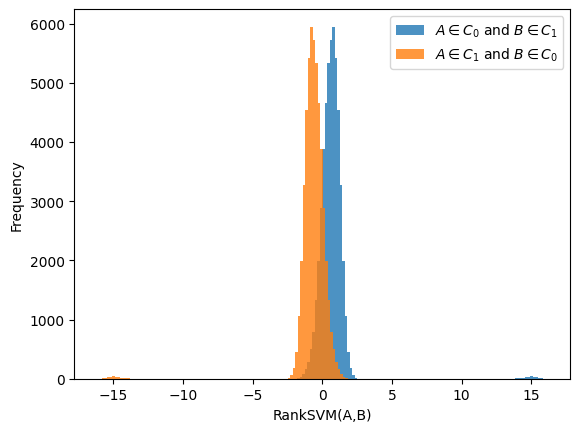

In [93]:
# Class distribution of training data
plt.hist(out_train[y_train==1], alpha=0.8, bins=100, label='$A \in C_0$ and $B \in C_1$') # A in C0 and B in C1 so score should be positive
plt.hist(out_train[y_train==-1], alpha=0.8, bins=100, label='$A \in C_1$ and $B \in C_0$') # A in C1 and B in C0 so score should be negative
plt.xlabel("RankSVM(A,B)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

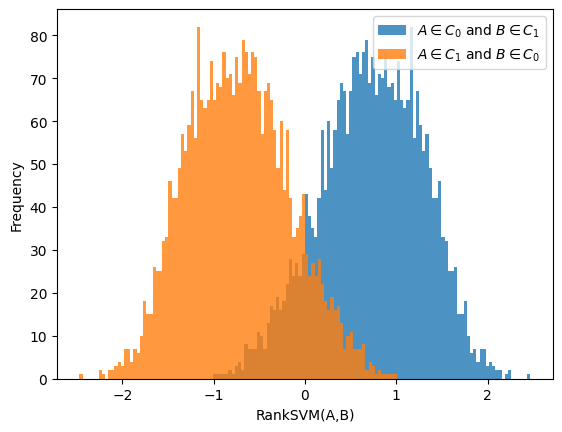

In [94]:
# Class distribution of test data
plt.hist(out_test[y_test==1], alpha=0.8, bins=100, label='$A \in C_0$ and $B \in C_1$') # A in C0 and B in C1 so score should be positive
plt.hist(out_test[y_test==-1], alpha=0.8, bins=100, label='$A \in C_1$ and $B \in C_0$') # A in C1 and B in C0 so score should be negative
plt.xlabel("RankSVM(A,B)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [95]:
def plot_density(X_train: np.ndarray, y_train: np.ndarray, criterion_1: int, criterion_2: int, samples: int = 10000) -> None:
    """Plot the density of the training data and the decision boundary. Plots only pairs of criteria criterion_1 and criterion_2. 

    Args:
        X_train (np.ndarray): Input features of the training data.
        y_train (np.ndarray): Target variable of the training data.
        criterion_1 (int): The index of the first criterion.
        criterion_2 (int): The index of the second criterion.
        samples (int, optional): The number of samples to plot. Defaults to 10000.

    """
    # Plot the density of the training data
    axes = sns.jointplot(
        x=X_train[:samples, criterion_1],
        y=X_train[:samples, criterion_2],
        hue=y_train[:samples],
        kind="kde",
        palette=["green", "red"],
        fill=True,
        alpha=0.5,
    )
    
    # Plot the decision boundary
    x_points = np.linspace(-2*w[criterion_2], 2*w[criterion_2])
    y_points = -(w[criterion_1] / w[criterion_2]) * x_points - b / w[criterion_2]
    x_points = x_points[np.logical_and(y_points < 1, y_points > -1)]
    y_points = y_points[np.logical_and(y_points < 1, y_points > -1)]
    axes.ax_joint.plot(x_points, y_points, c="blue")
    
    # Set labels for axes
    axes.ax_joint.set_xlabel(f"Criterion: {criterion_1}")
    axes.ax_joint.set_ylabel(f"Criterion: {criterion_2}")

In [96]:
# Model coefficients
w = model.coef_[0]
print(f'Criteria coefficients {w}')
b = model.intercept_[0]
print(f'Intercept {b}')

Criteria coefficients [1.05003175 0.31338457 0.20354584 0.24750043 0.03960803]
Intercept 8.135832482296683e-09


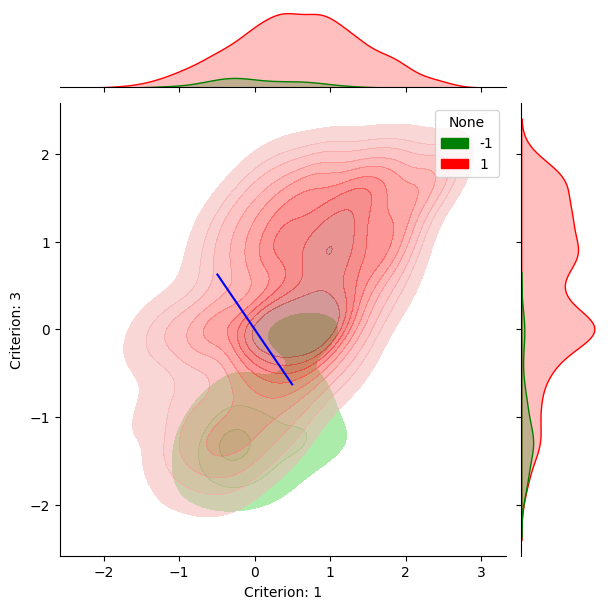

In [97]:
c_1 = 1
c_2 = 3
plot_density(X_train, y_train, c_1, c_2, samples=1000)

### **1.2 Explanation of the decisions** ###

In [98]:
import dalex as dx
import shap
import lime
import warnings

warnings.filterwarnings("ignore")

In [99]:
w = model.coef_
b = model.intercept_

In [100]:
print(w)
print(b)

[[1.05003175 0.31338457 0.20354584 0.24750043 0.03960803]]
[8.13583248e-09]


**Reminder**: SVM produces output based on following equation:
$$
f(x) = \mathbf{w}^\top \mathbf{x} + b
$$

and:

$$
x = x1 - x2
$$

If f(x) is greater than 0, then x1 is preffered over x2 and vice versa

#### **1.2.1 Alternative 1**

In [101]:
a1_x = (a241[0] - a400[0]).reshape(1, -1)
a1_x = scaller.transform(a1_x)

a1_y = a241[1] - a400[1] # 1
a1_x

array([[ 0.27519758,  0.13101908,  1.67373546,  1.71484074, -1.70102868]])

In [102]:
a1_y_pred = model.predict(a1_x)[0]
a1_y_pred # corresponding to real value

1

**Explaining the prediction - based only on input values**

To explain the prediction we can go back to section 0.3 - a241 is clearly a patient with malignant breast mass and a400 is very likely a patient with benign breast mass. In both cases the true class can be said without creating any models, thus the differences should be relatively high and indeed they are. 

**What should be minimal change to flip the class?**

Since SVM works based on the equation that was written above, we need to find such a values that will result function being negative. To do this we can see which feature holds the highest absolute value of parameter - in our case this is feature 1 (or 0 if we index from 0) - changing this feature impacts output of the model the most and we need to find this impact while leaving rest of parameters unchanged. 

In [103]:
print(f"Minimal change of first feature equals: \t{-(a1_x[:, 1:] @ w[0, 1:].T + b)[0]/w[0][0]:.4}")

Minimal change of first feature equals: 	-0.7036


This change is minimal because the magnitude of first feature is the highest - we need to change other parameters more to achieve the same result

**Space sampling**

In [104]:
number_of_samples = 100_000
for i in range(criteria_nr):
    mini = np.min(X_train[:, i])
    maxi = a1_x[0, i]
    for val in np.linspace(-30, maxi, num=number_of_samples)[::-1]:
        a1_x_modified = a1_x.copy()
        a1_x_modified[0, i] = val
        y_pred = model.predict(a1_x_modified)
        if (y_pred == -1):
            print(f"Minimal change for feature {i} to flip class while keeping other values unchanged is {val:.4}")
            break

Minimal change for feature 0 to flip class while keeping other values unchanged is -0.7036
Minimal change for feature 1 to flip class while keeping other values unchanged is -3.149
Minimal change for feature 2 to flip class while keeping other values unchanged is -3.376
Minimal change for feature 3 to flip class while keeping other values unchanged is -2.438
Minimal change for feature 4 to flip class while keeping other values unchanged is -27.65


And as we can see above, for feature 0 the values are exactly the same as the one we computed one section earlier. Also one remark should be made, to flip classes by changing only features 2, 3 or 4 we need to decrease it to a value that does not occur for this particular feature in dataset (minimum for feature 4 is slightly below -15 but to flip the class it has to be decreased to -27.65).

**Explaining the predictions**

**1. Shap**

[[ 0.32075232  0.02258229  0.39632661  0.45307244 -0.06602691]]


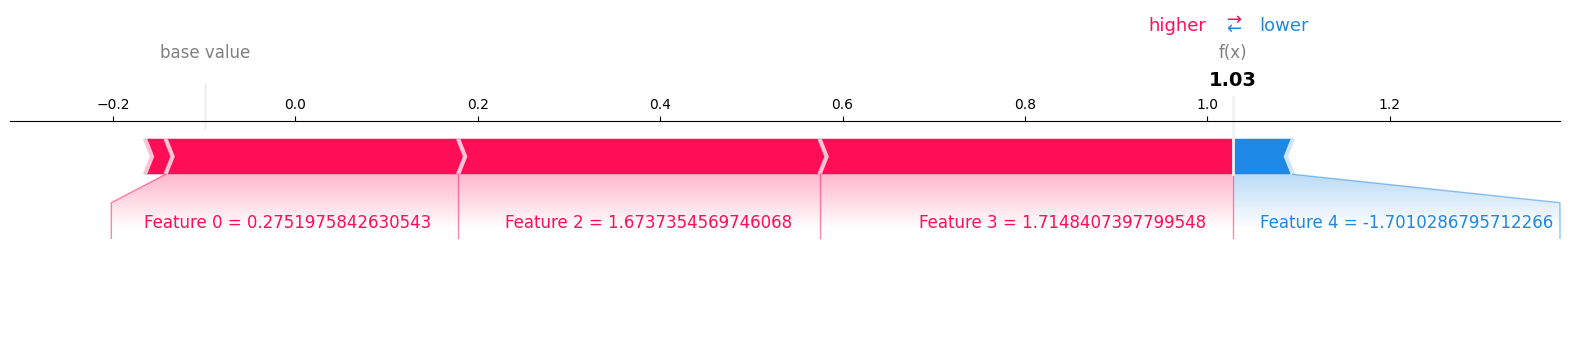

In [105]:
explainer = shap.LinearExplainer(model, X_train, feature_perturbation="interventional")
shap_values = explainer.shap_values(a1_x)
print(shap_values)
shap.force_plot(explainer.expected_value, shap_values, a1_x, matplotlib=True)

As we can see above, there are 4 features that "push" the prediction higher (towards class 1 - patient 241 is more likely to have malignant mass than patient 400) and 1 feature that "pushes" class lower. Features 0, 2 and 3 have high contribution to the prediction, thus mostly thanks to them model returns prediction equal to 1. Feature 1 has little positive influence on the model and feature 4 has slightly higher but still little negative influence on the model. 

Now we can come back to our dataset - model returned value 1 (alternative 241 is preferred over alternative 400) mostly because of features 0, 2 and 3. In other words, the patient number 241 has higher value for attribute 0 (BI-RADS), higher value for attribute 2 (Irregular shape vs round shape) and higher value for attribute 3 (spiculated margin vs circumsribed margin) and thus model predicts that she is sick (which we already pointed out in section 0.3). 

**Conclusion**: Results of experiment correspond to our raw predictions.

**2. LIME**

In [106]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train, 
                                                   feature_names=['BI-RADS', 'Age', 'Shape', 'Margin', 'Density'], 
                                                   class_names=[-1, 1], 
                                                   mode='regression',
                                                   discretize_continuous=True)

exp = explainer.explain_instance(a1_x[0], model.decision_function, num_features=5)

# Display the explanation
exp.show_in_notebook(show_table = True)

#### **1.2.2 Alternative 2**

In [108]:
a2_x = (a573[0] - a828[0]).reshape(1, -1)
a2_x = scaller.transform(a2_x)

a2_y = a573[1] - a828[1] # -1
a2_x

array([[-2.75197584e-01, -5.67758429e-01, -5.57911261e-01,
        -4.28710185e-01, -3.67547549e-16]])

In [109]:
a2_y_pred = model.predict(a2_x)[0]
a2_y_pred # corresponding to real value

-1

**Explaining the prediction - based only on input values**

To explain the prediction we can go back to section 0.3 - a573 is clearly a patient with benign breast mass and a828 is very likely a patient with malignant breast mass. 

**What should be minimal change to flip the class?**

Since SVM works based on the equation that was written above, we need to find such a values that will result function being negative. To do this we can see which feature holds the highest absolute value of parameter - in our case this is feature 1 (or 0 if we index from 0) - changing this feature impacts output of the model the most and we need to find this impact while leaving rest of parameters unchanged. 

In [110]:
print(f"Minimal change of first feature equals: \t{-(a2_x[:, 1:] @ w[0, 1:].T + b)[0]/w[0][0]:.4}")

Minimal change of first feature equals: 	0.3786


This change is minimal because the magnitude of first feature is the highest - we need to change other parameters more to achieve the same result

**Space sampling**

In [ ]:
number_of_samples = 100_000
for i in range(criteria_nr):
    mini = np.min(X_train[:, i])
    for val in np.linspace(mini, 30, num=number_of_samples):
        a2_x_modified = a2_x.copy()
        a2_x_modified[0, i] = val
        y_pred = model.predict(a2_x_modified)
        if (y_pred == 1):
            print(f"Minimal change for feature {i} to flip class while keeping other values unchanged is {val:.4}")
            break

Minimal change for feature 0 to flip class while keeping other values unchanged is 0.3789
Minimal change for feature 1 to flip class while keeping other values unchanged is 1.623
Minimal change for feature 2 to flip class while keeping other values unchanged is 2.815
Minimal change for feature 3 to flip class while keeping other values unchanged is 2.345
Minimal change for feature 4 to flip class while keeping other values unchanged is 17.33


And as we can see above, for feature 0 the values are almost exactly the same as the one we computed one section earlier. Also one remark should be made, to flip classes by changing only features 2, 3 or 4 we need to increase it to a value that does not occur for this particular feature in dataset (minimum for feature 4 is slightly more than 15 but to flip the class it has to be increased to 17.33).

**Explaining the predictions**

**Shap**

[[-0.25718008 -0.19640379 -0.0579158  -0.07745735  0.00134748]]


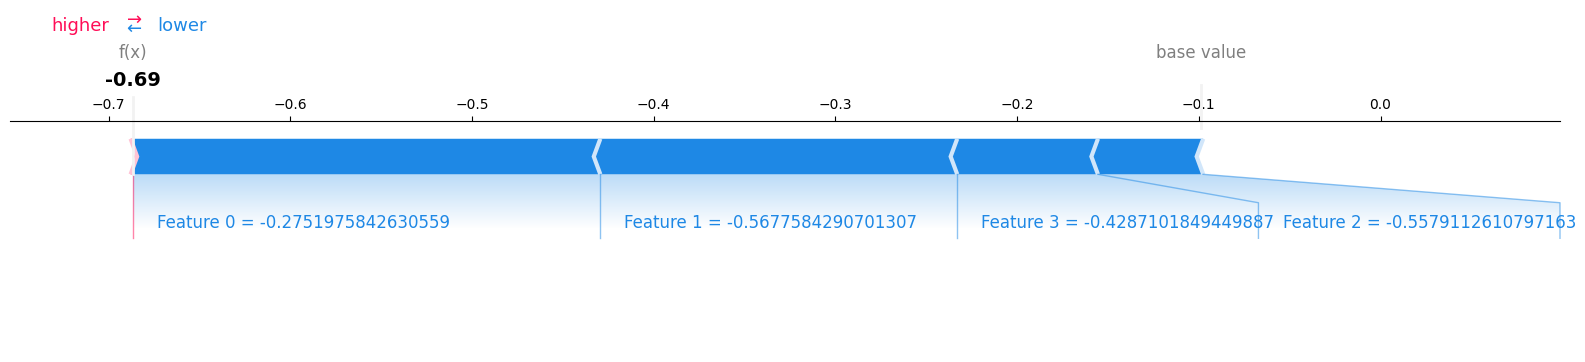

In [113]:
explainer = shap.LinearExplainer(model, X_train, feature_perturbation="interventional")
shap_values = explainer.shap_values(a2_x)
print(shap_values)
shap.force_plot(explainer.expected_value, shap_values, a2_x, matplotlib=True)

As we can see above, there are 5 features that "push" the prediction lower (it means, the alternative a573 is NOT preferred to a828) and 1 feature that "pushes" class higher (towards the a573 is preferred to a828). Features 1, 2 and 3 have high negative contribution to the prediction, thus mostly thanks to them model returns -1 prediction. Feature 4 has very very little positive influence on the model. 

Now we can come back to our dataset - model returned value 1 (alternative 573 is not preferred over alternative 828; a573 has lower chances of being malignant breast mass) mostly because of difference on features 1, 2 and 3. 

**Conclusion**: Results of experiment correspond to our raw predictions.

#### **1.2.3 Alternative 3**

In [117]:
a3_x = (a241[0] - a573[0]).reshape(1, -1)
a3_x = scaller.transform(a3_x)

a3_y = a241[1] - a573[1] # 1
a3_x

array([[ 0.27519758, -0.82979999,  0.55791126,  0.42871018, -1.70102868]])

In [118]:
a3_y_pred = model.predict(a3_x)[0]
a3_y_pred # corresponding to real value

1

**Explaining the prediction - based only on input values**

To explain the prediction we can go back to section 0.3 - a241 is clearly a patient with malignant breast mass and a573 is very likely a patient with benign breast mass. 

**What should be minimal change to flip the class?**

Since SVM works based on the equation that was written above, we need to find such a values that will result function being negative. To do this we can see which feature holds the highest absolute value of parameter - in our case this is feature 1 (or 0 if we index from 0) - changing this feature impacts output of the model the most and we need to find this impact while leaving rest of parameters unchanged. 

In [119]:
print(f"Minimal change of first feature equals: \t{-(a3_x[:, 1:] @ w[0, 1:].T + b)[0]/w[0][0]:.4}")

Minimal change of first feature equals: 	0.1026


This change is minimal because the magnitude of first feature is the highest - we need to change other parameters more to achieve the same result

**Space sampling**

In [120]:
number_of_samples = 100_000
for i in range(criteria_nr):
    maxi = a1_x[0, i]
    for val in np.linspace(-30, maxi, num=number_of_samples)[::-1]:
        a3_x_modified = a3_x.copy()
        a3_x_modified[0, i] = val
        y_pred = model.predict(a3_x_modified)
        if (y_pred == -1):
            print(f"Minimal change for feature {i} to flip class while keeping other values unchanged is {val:.4}")
            break

Minimal change for feature 0 to flip class while keeping other values unchanged is 0.1023
Minimal change for feature 1 to flip class while keeping other values unchanged is -1.408
Minimal change for feature 2 to flip class while keeping other values unchanged is -0.3325
Minimal change for feature 3 to flip class while keeping other values unchanged is -0.3035
Minimal change for feature 4 to flip class while keeping other values unchanged is -6.276


And as we can see above, for feature 0 the values are almost exactly the same as the one we computed one section earlier. Also one remark should be made, to flip classes by changing only features 2, 3 or 4 we need to increase it to a value that does not occur for this particular feature in dataset (minimum for feature 4 is slightly more than 15 but to flip the class it has to be increased to 17.33).

**Explaining the predictions**

**Shap**

[[ 0.32075232 -0.27852358  0.16920524  0.13475457 -0.06602691]]


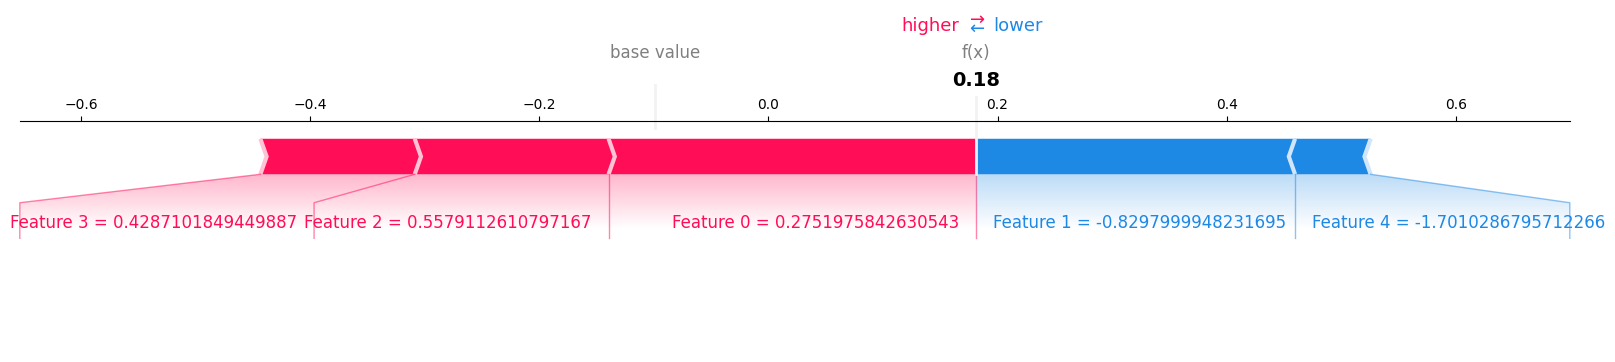

In [121]:
explainer = shap.LinearExplainer(model, X_train, feature_perturbation="interventional")
shap_values = explainer.shap_values(a3_x)
print(shap_values)
shap.force_plot(explainer.expected_value, shap_values, a3_x, matplotlib=True)

In this case, the situation is more interesting, i. e. some fatures push the prediction lower (1 and 4) while some push them higher (0, 2, 3). And that makes much sense - on the features that are positive we have positive shap values and vice versa (which is logical because all criteria are of gaintype, thus the higher the better). However, out of all cases this prediction seems to be the weakest (prediction is 1 and real value is 1 but the probability is low)

### **1.3 Interpretation of the model** ###

In [31]:
print('Weights of the model:', w[0])
print('Intercept of the model:', b[0])
print('Input values of alternative a1:', a1_x)
print('a1_x * w', a1_x * w)

Weights of the model: [1.05003177 0.31338458 0.20354586 0.24750046 0.03960803]
Intercept of the model: -1.1041442751991365e-08
Input values of alternative a1: [[ 0.27519758  0.13101908  1.67373546  1.71484074 -1.70102868]]
a1_x * w [[ 0.28896621  0.04105936  0.34068192  0.42442387 -0.06737439]]


**Can we say anything about the model only based on parameters?**

Yes - for positive values, model is more likely to predict class 1 (it means a S b), especially if parameters 0, 2 and 3 are positive (highest params).

**Are there any criteria with very high or almost no influence?**

Most important feature for our model is the first one and last one gives us almost no information. Thus, if we have (relatively) very high or very low value of first feature, we can try to make a prediction based on it. However, we also need to take into account the fact that values of feature 0 are smaller than values of feature 2 and 3 (example above), thus sometimes it can be more logical to take into account a product of feature value and its weight (in that case features 2 and 3 will have higher influence on the model). Feature 4 gives us almost no influence on the model no matter if we take into account only appropriate parameter or its product with feature value.

In [ ]:
# DALEX Variable Importance; Partial Dependency Plot
x = X_test[:]
y = y_test[:]

exp = dx.Explainer(model, x, y)
fi = exp.model_parts(B = 300, random_state = 42)
fi.plot()

Preparation of a new explainer is initiated

  -> data              : numpy.ndarray converted to pandas.DataFrame. Columns are set as string numbers.
  -> data              : 6372 rows 5 cols
  -> target variable   : 6372 values
  -> model_class       : sklearn.svm._classes.LinearSVC (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_default at 0x3108ba550> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = -1.0, mean = -0.000314, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -2.0, mean = 0.000314, max = 2.0
  -> model_info        : package sklearn

A new explainer has been created!


**Explanation**: Out of all criteria, the most insightful one is criterion 0 and least is criterion 1. It does not say which criterion is good and which is bad, but how did the loss increased (or decreased) when the feature was permuted. We see that making noise on feature 1 decreases the loss (which is strange) but doing the same with feature 0 increases the loss pretty much.

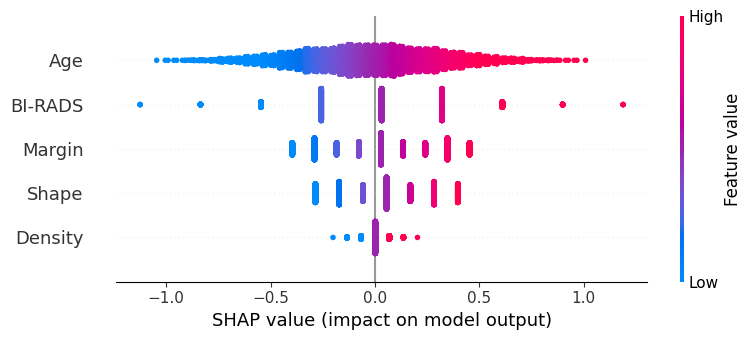

In [122]:
# SHAP
feature_names = ['BI-RADS', 'Age', 'Shape', 'Margin', 'Density']
explainer = shap.LinearExplainer(model, X_train, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names=feature_names)

According to above plots, the highest influence on the prediction have features 0 (BI-RADS) and 1 (Age) - the higher the value, the more probable it is that predicted class will be 1. Feature 4 (Density) has the smallest influence (is the lowest of all attributes). This complies with our model parameters (they are the highest for features 0 and 1; they are the lowest for feature 4).

**Are there any dependencies between criteria?**

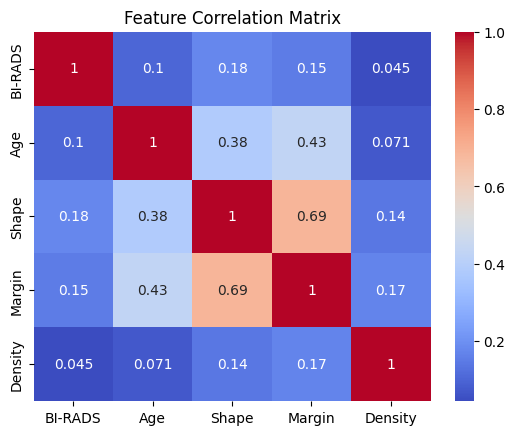

In [123]:
X = pd.DataFrame(X_train, columns=feature_names)

sns.heatmap(X.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

As we can see above, for most features there is no correlation (value of correlation <0.2). However, there is one pair of attributes that have relatively high correlation coefficient - Margin and Shape (coefficient = 0.69), which indicates moderately strong linear dependency between two features. There are also pairs with coefficients close to 0.4 (Age and Shape; Age and Margin) which suggests moderate linear dependency between two. Rest attributes has weak or no dependency.

**What is the nature of the criteria**

For our model, parameters for all features are greater than 0, thus all criteria are of gain type (which is similar to what was said in section with dataset decription). This means that if higher feature values (difference between two measurements) indicate higher class (malignant breast mass). This can also be visible on SHAP summary_plot - higher values of criteria indicate higher class (class 1 - malignant breast mass).

In [160]:
# DALEX Aggregated profiles
exp.model_profile().plot()

Calculating ceteris paribus: 100%|██████████| 5/5 [00:00<00:00, 129.40it/s]


**Explanation**: Another interesting visualization is AggregatedProfiles - this clearly shows type of criteria. If value of criterion rises, then predicted class also rises (this is true for all criteria), thus all criteria are gain type.

## **2. ANN-UTADIS** ##

In [6]:
import torch
from utils import *
from uta import Uta
from norm_layer import NormLayer

PATH = "uta.pt2"

/Users/Kuba/Library/Python/3.9/lib/python/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [153]:
# Load data, split into train and test sets and create dataloaders
path = "monodata/mammographic.csv"
data = pd.read_csv(path, header=None)
target_map = {0: 0, 1: 1}
num_criteria = 5
data_input = data.iloc[:, :num_criteria]
data_target = data[num_criteria].apply(lambda x: target_map[x])

data_input = data_input.values.reshape(-1, 1, num_criteria)

X_train, X_test, y_train, y_test = train_test_split(
    data_input, data_target.values, test_size=0.2, random_state=1234
)

train_dataloader = CreateDataLoader(X_train, y_train)
test_dataloader = CreateDataLoader(X_test, y_test)

In [154]:
# Create model and train
uta = Uta(num_criteria, 30)
model = NormLayer(uta, num_criteria)
(
    best_acc,
    best_auc,
    stats_train,
    stats_test,
) = Train(model, train_dataloader, test_dataloader, PATH, epoch_nr=200,lr =0.0001,slope_decrease=True)

100%|██████████| 200/200 [00:00<00:00, 205.47it/s]


In [155]:
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [156]:
hook = Hook(model.method_instance.monotonic_layer, append_output)
xs = []
with torch.no_grad():
    for i in range(201):
        val = i / 200.0
        x = get_simple_input(val,num_criteria)
        xs.append(val)
        model(x)

outs = np.array(torch.stack(hook.stats)[:, 0].detach().cpu())
# We take every third value becouse the rest are from the normalization layer: velues for 0 and 1
outs = outs[::3] - outs[::3][0]
# Normalize the outputs to get proper weights of the criteria
outs = outs / outs[-1].sum()

In [157]:
y_train_pred = []
y_train_score = []

model.eval()
with torch.no_grad():
    for x, y in zip(X_train, y_train):
        x = torch.tensor(x, dtype=torch.float32).unsqueeze(0)
        output = model(x).item()
        predicted = int(output > 0)
        y_train_pred.append(predicted)
        y_train_score.append(output)

In [158]:
y_test_pred = []
y_test_score = []

model.eval()
with torch.no_grad():
    for x, y in zip(X_test, y_test):
        x = torch.tensor(x, dtype=torch.float32).unsqueeze(0)
        output = model(x).item()
        predicted = int(output > 0)
        y_test_pred.append(predicted)
        y_test_score.append(output)

### **2.1.1 Basic metrics**

In [159]:
accuracy_train = accuracy_score(y_train_pred, y_train)
auc_train = roc_auc_score(y_train, y_train_score) 
f1_train = f1_score(y_train_pred, y_train)

accuracy_test = accuracy_score(y_test_pred, y_test)
auc_test = roc_auc_score(y_test, y_test_score)
f1_test = f1_score(y_test_pred, y_test)

In [160]:
print(f"Accuracy train:\t{accuracy_train:.2%}")
print(f"AUC train: \t{auc_train:.2%}")
print(f"F1 train:\t{f1_train:.4}\n")

print(f"Accuracy test:\t{accuracy_test:.2%}")
print(f"AUC test: \t{auc_test:.2%}")
print(f"F1 train:\t{f1_test:.4}\n")

Accuracy train:	80.57%
AUC train: 	86.47%
F1 train:	0.8031

Accuracy test:	78.92%
AUC test: 	84.89%
F1 train:	0.7445



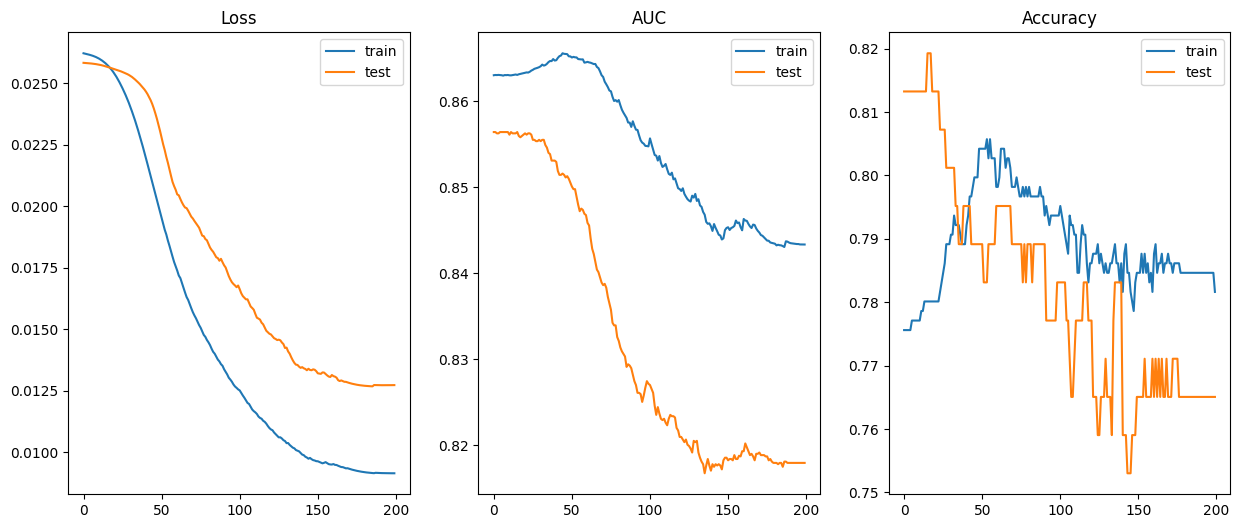

In [161]:
# Plot results
fig = plt.figure(figsize=(15,6))

ax = fig.add_subplot(131)
ax.plot(stats_train.losses,label='train')
ax.plot(stats_test.losses,label='test')
ax.set_title('Loss')
ax.legend()

ax = fig.add_subplot(1,3,2)
ax.plot(stats_train.auc_scores,label='train')
ax.plot(stats_test.auc_scores,label='test')
ax.set_title('AUC')
ax.legend()

ax = fig.add_subplot(1,3,3)
ax.plot(stats_train.acc_scores,label='train')
ax.plot(stats_test.acc_scores,label='test')
ax.set_title('Accuracy')
ax.legend()

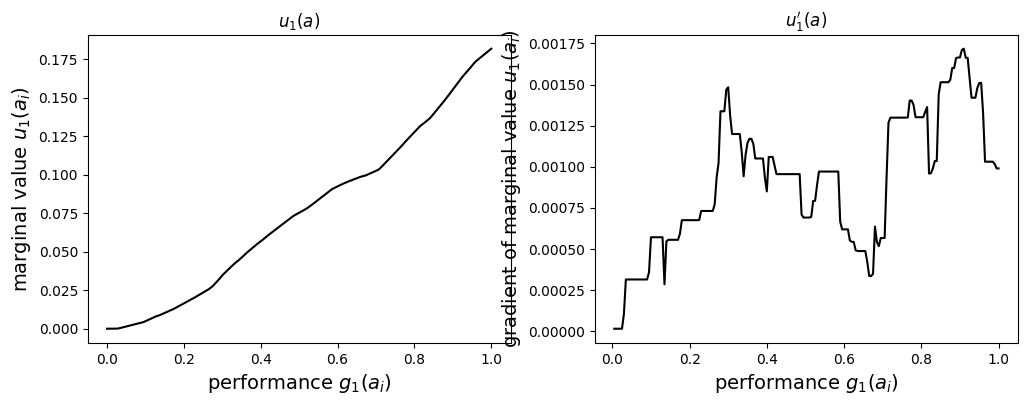

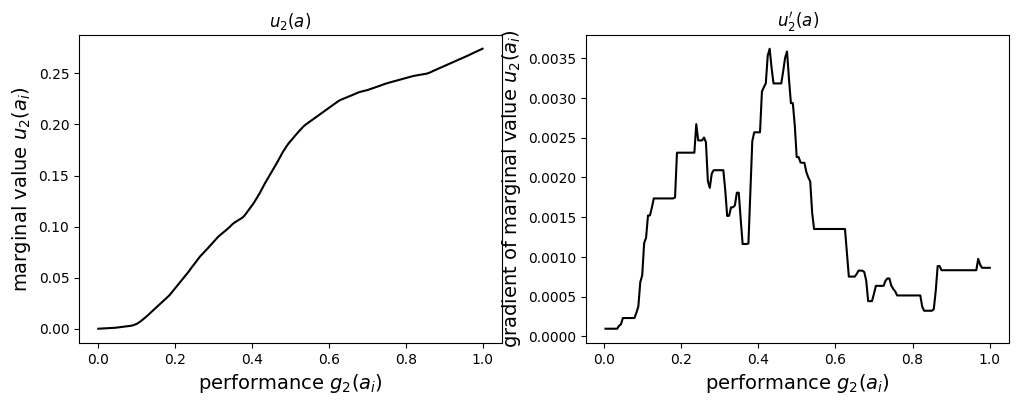

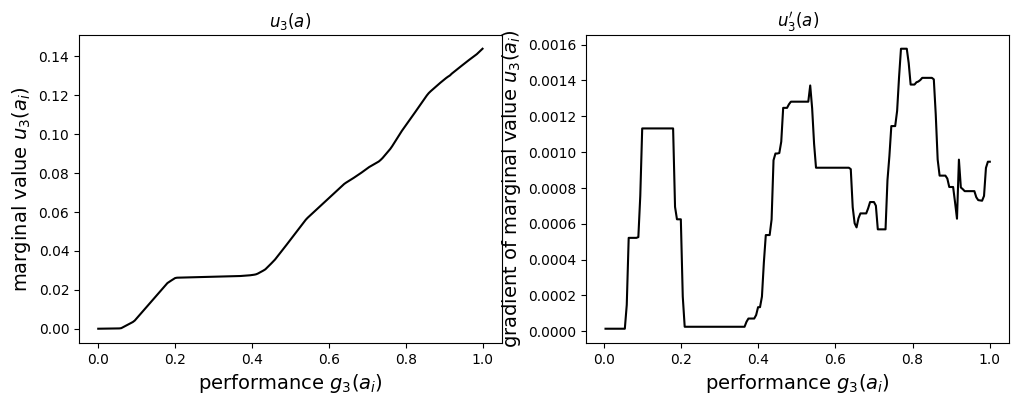

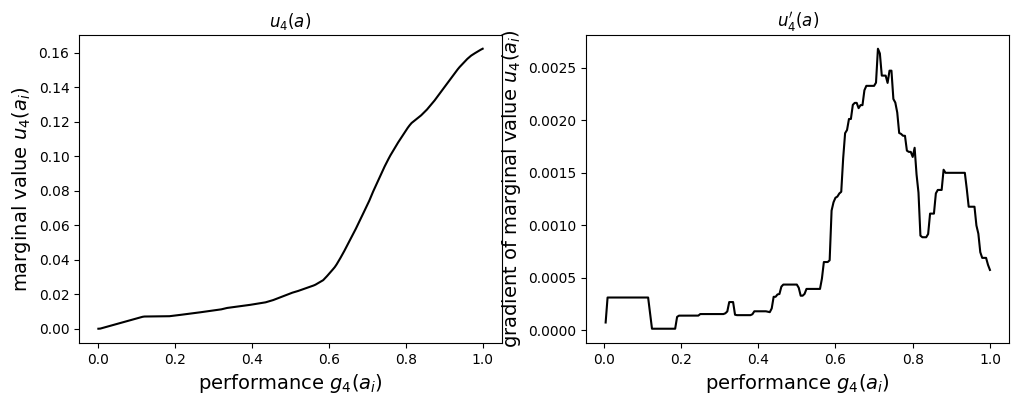

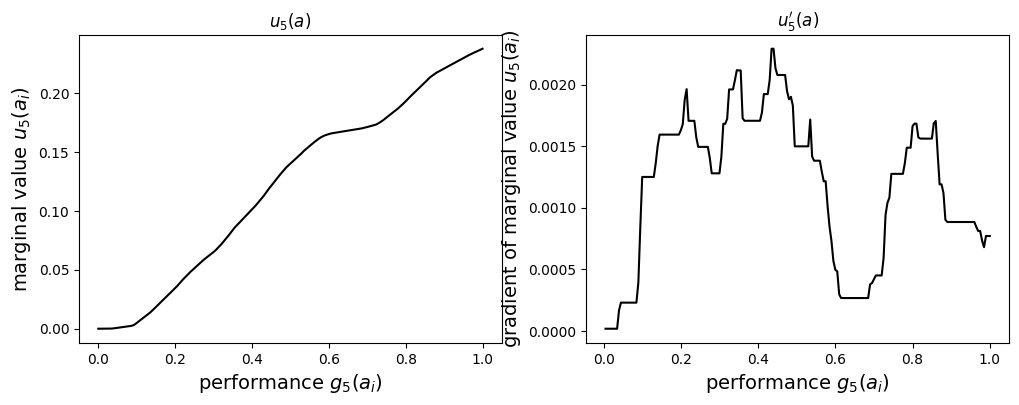

In [162]:
for i in range(num_criteria):
    criterion_number = i + 1
    fig = plt.figure(figsize=(12,4))  
    ax = fig.add_subplot(121)
    ax.set_title(f'$u_{criterion_number}(a)$')
    ax.plot(xs, outs[:, i], color="black")
    ax.set_ylabel(f"marginal value $u_{criterion_number}(a_i)$", fontsize=14)
    ax.set_xlabel(f"performance $g_{criterion_number}(a_i)$", fontsize=14)

    ax = fig.add_subplot(1,2,2)
    ax.set_title(f"$u_{criterion_number}'(a)$")
    ax.plot(xs[1:], outs[1:, i]-outs[:-1, i], color="black")
    ax.set_ylabel(f"gradient of marginal value $u_{criterion_number}(a_i)$", fontsize=14)
    ax.set_xlabel(f"performance $g_{criterion_number}(a_i)$", fontsize=14)
    plt.show()

## **2.1. Explanation of the decisions**

In [ ]:
import torch
import numpy as np
from lime.lime_tabular import LimeTabularExplainer

# Define a prediction function for LIME; will be used later
def predict_fn(x):
    x_tensor = torch.tensor(x, dtype=torch.float32)
    with torch.no_grad():
        outputs = model(x_tensor)
        probs = torch.sigmoid(outputs).numpy()  # shape: (n_samples,) or (n_samples, 1)
        if probs.ndim == 1:
            probs = probs[:, np.newaxis]  # convert (n,) -> (n, 1)
        probs = np.concatenate([1 - probs, probs], axis=1)  # shape: (n, 2)
    return probs

In [55]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name}:\n{param.data}\n")

method_instance.monotonic_layer.criterion_layer_spread.bias:
tensor([[-0.2539, -0.7624, -0.8215, -0.4817, -0.2906],
        [-0.8493, -0.7595, -0.3935, -0.6630, -0.9474],
        [-0.9835, -0.3186, -0.0867, -0.8769, -0.5930],
        [-0.0776, -0.8785, -0.5345, -0.9317, -0.9309],
        [-0.2163, -0.7059, -0.3341, -0.8005, -0.3666],
        [-0.8130, -0.9417, -0.7214, -0.8881, -0.9590],
        [-0.5937, -0.6574, -0.5714, -0.1192, -0.8347],
        [-0.9038, -0.5270, -0.4061, -0.1556, -0.0316],
        [-0.3155, -0.3385, -0.7652, -0.4627, -0.5419],
        [-0.1839, -0.8563, -0.9319, -0.2829, -0.5241],
        [-0.0951, -0.5106, -0.7568, -0.2360, -0.0470],
        [-0.4245, -0.3947, -0.5007, -0.6354, -0.0722],
        [-0.5395, -0.5398, -0.5580, -0.9233, -0.5900],
        [-0.5114, -0.3507, -0.1054, -0.1446, -0.6429],
        [-0.0094, -0.4333, -0.3701, -0.3585, -0.6688],
        [-0.4721, -0.0269, -0.5789, -0.7288, -0.4514],
        [-0.5953, -0.9168, -0.2592, -0.5672, -0.9210],
    

### **Alternative 1**

In [145]:
a400_x, a400_y = a400
print(a400_x)
print(a400_y)

[0.072727 0.166667 0.       0.       0.666667]
0


In [146]:
with torch.no_grad():
    x = torch.tensor(a400_x, dtype=torch.float32).unsqueeze(0)
    output = model(x).item()
    predicted = int(output > 0)
    print(output)

-0.3175756335258484


**Why the decision was made?**

First of all, for alternative 400 we had small values on features 0-3 and high value on criterion 4. Since sum of marginal values will be low, we can estimate that the class will be 0 and mass will be benign.

#### **What should be the minimal change to flip the class?** ####

**Method without sampling**

It is not so easy to estimate it but I would say that we should change value for the feature 1 as it seems to be the most important one. However it is difficult to calculate the proper value.

**Method with sampling**

In [171]:
number_of_samples = 100_000
for i in range(criteria_nr):
    mini = np.min(X_train[:, 0, i])
    for val in np.linspace(mini, 100, num=number_of_samples):
        a1_x_modified = a400_x.copy()
        a1_x_modified[i] = val
        
        with torch.no_grad():
            x = torch.tensor(a1_x_modified, dtype=torch.float32).unsqueeze(0)
            output = model(x).item()
            predicted = int(output > 0)
        
        if (predicted == 1):
            print(f"Minimal change for feature {i} to flip class while keeping other values unchanged is {val:.4}")
            break

Minimal change for feature 0 to flip class while keeping other values unchanged is 31.28
Minimal change for feature 1 to flip class while keeping other values unchanged is 5.403
Minimal change for feature 2 to flip class while keeping other values unchanged is 46.14
Minimal change for feature 3 to flip class while keeping other values unchanged is 45.55
Minimal change for feature 4 to flip class while keeping other values unchanged is 54.66


**Explanation of the decision**

In [198]:
X_train_reshaped=X_train.reshape(664, 5)

# Create a LIME explainer
explainer = LimeTabularExplainer(
    training_data=X_train_reshaped,      # numpy array of training data
    feature_names=feature_names,   # list of feature names
    class_names=['benign', 'malignant'],       # list of class labels (strings)
    mode='classification'
)
explanation = explainer.explain_instance(
    data_row=a400_x,
    predict_fn=predict_fn,
    num_features=5
)

# Show explanation
explanation.show_in_notebook()

As we see, according to LIME all feature values vote for benign class (which is true - check previous sections) - young patient and mass that is round, has circumscribed margins and iso density (even for someone who is not expert it is almost obvious that it is healthy mass).

**NOTE**: if you view this notebook in dark mode, above visualization may look ugly due to black fonts. However, I have little idea how to fix this apart from changing mode of notebook.

### **Alternative 2** ###

In [173]:
a573_x, a573_y = a573
print(a573_x)
print(a573_y)

[0.072727 0.448718 0.666667 0.75     0.666667]
0


In [174]:
with torch.no_grad():
    x = torch.tensor(a573_x, dtype=torch.float32).unsqueeze(0)
    output = model(x).item()
    predicted = int(output > 0)
    print(output)

-0.00016814470291137695


**Why the decision was made?**

In this case we have values that are higher than the values for alternative 400 but not that high to belong to class 1. However, as we can see the score obtained by model is close to 0, thus it is on the boundary of two classes

#### **What should be the minimal change to flip the class?** ####

**Method without sampling**

It is not so easy to estimate it but I would say that we should change value for the feature 1 as it seems to be the most important one. However it is difficult to calculate the proper value.

**Method with sampling**

In [176]:
number_of_samples = 100_000
for i in range(criteria_nr):
    mini = np.min(X_train[:, 0, i])
    for val in np.linspace(mini, 100, num=number_of_samples):
        a2_x_modified = a573_x.copy()
        a2_x_modified[i] = val
        
        with torch.no_grad():
            x = torch.tensor(a2_x_modified, dtype=torch.float32).unsqueeze(0)
            output = model(x).item()
            predicted = int(output > 0)
        
        if (predicted == 1):
            print(f"Minimal change for feature {i} to flip class while keeping other values unchanged is {val:.4}")
            break

Minimal change for feature 0 to flip class while keeping other values unchanged is 0.076
Minimal change for feature 1 to flip class while keeping other values unchanged is 0.449
Minimal change for feature 2 to flip class while keeping other values unchanged is 0.668
Minimal change for feature 3 to flip class while keeping other values unchanged is 0.751
Minimal change for feature 4 to flip class while keeping other values unchanged is 0.67


**Explaining the prediction**

In [197]:
X_train_reshaped=X_train.reshape(664, 5)

# Create a LIME explainer
explainer = LimeTabularExplainer(
    training_data=X_train_reshaped,      # numpy array of training data
    feature_names=feature_names,   # list of feature names
    class_names=['benign', 'malignant'],       # list of class labels (strings)
    mode='classification'
)
explanation = explainer.explain_instance(
    data_row=a573_x,
    predict_fn=predict_fn,
    num_features=5
)

# Show explanation
explanation.show_in_notebook()

In this case both classes have the same probability (our model returned value which was very close to 0) and most features vote for class benign, except for feature Margin (ill-defined). Two most influential features are Density and Margin, rest gives us little info. We can see that in this example features vote against each other and thus the model has difficulty to make a good decision.

### **Alternative 3**

In [149]:
a828_x, a828_y = a828
print(a828_x)
print(a828_y)

[0.090909 0.615385 1.       1.       0.666667]
1


In [150]:
with torch.no_grad():
    x = torch.tensor(a828_x, dtype=torch.float32).unsqueeze(0)
    output = model(x).item()
    predicted = int(output > 0)
    print(output)

0.13954812288284302


**Why the decision was made?**

For this alternative we have high values of almost all criteria, thus a828 almost for sure will be of class 1.

#### **What should be the minimal change to flip the class?** ####

**Method without sampling**

It is not so easy to estimate it but I would say that we should change value for the feature 1 as it seems to be the most important one. However it is difficult to calculate the proper value.

**Method with sampling**

In [178]:
number_of_samples = 100_000
for i in range(criteria_nr):
    maxi = np.max(X_train[:, 0, i])
    for val in np.linspace(-100, maxi, num=number_of_samples)[::-1]:
        a3_x_modified = a828_x.copy()
        a3_x_modified[i] = val
        
        with torch.no_grad():
            x = torch.tensor(a3_x_modified, dtype=torch.float32).unsqueeze(0)
            output = model(x).item()
            predicted = int(output > 0)
        
        if (predicted == 0):
            print(f"Minimal change for feature {i} to flip class while keeping other values unchanged is {val:.4}")
            break

Minimal change for feature 0 to flip class while keeping other values unchanged is -67.23
Minimal change for feature 1 to flip class while keeping other values unchanged is 0.1445
Minimal change for feature 2 to flip class while keeping other values unchanged is -19.94
Minimal change for feature 3 to flip class while keeping other values unchanged is -14.02
Minimal change for feature 4 to flip class while keeping other values unchanged is -8.614


**Explaining the prediction**

In [ ]:
X_train_reshaped=X_train.reshape(664, 5)

# Create a LIME explainer
explainer = LimeTabularExplainer(
    training_data=X_train_reshaped,      # numpy array of training data
    feature_names=feature_names,   # list of feature names
    class_names=['benign', 'malignant'],       # list of class labels (strings)
    mode='classification'
)
explanation = explainer.explain_instance(
    data_row=a828_x,
    predict_fn=predict_fn,
    num_features=5
)

# Show explanation
explanation.show_in_notebook()

In last case model predicts malignant breast mass. This is mostly achieved because Margin and Shape have values that point to malignant class (very influential). On the other hand, there is also Density attribute that votes for benign class and has relatively high importance. There are also two more attributes - one pushing for benign and one for malignant class. However, if we take into account the importance of each feature it is obvious that the breast mass must be malignant.

## **2.2.2. Interpretation of the model**

**Can we say anything about user preferences?**

Yes, user takes into account mostly features 0, 1 and 4. Less important are features 2 and 3.

**What is the influence of the criteria?**

According to our model, the most important criterion seems to be last one (Density), because its maximal value marginal value function is the highest. The least important criteria are criteria 2 and 3 (almost the same importance) - here the maximal value of marginal value function is the lowest (0.08 and 0.1)

**Are there any dependencies between criteria?**

(664, 5)


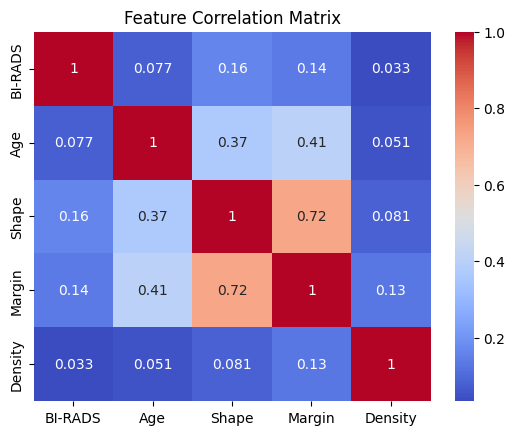

In [ ]:
X_train_reshaped = X_train.reshape(664, 5)
X = pd.DataFrame(X_train_reshaped, columns=feature_names)

sns.heatmap(X.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

As we can see most features are not correlated (corr < 0.2). However, there are 3 pairs of criteria that can be considered somehow correlated: (Age, Shape), (Age, Margin), (Shape, Margin). I have no idea where does this come from in terms of medicine but the correlation coefficients show moderate correlation for first two pairs and moderately strong correlation between Shape and Margin.

**Nature of criteria**

All criteria are of gaintype (marginal value function rises).

**Model interpretation**

In [ ]:
import torch
import numpy as np
import dalex as dx
from sklearn.tree import DecisionTreeClassifier

def predict_fn(x):
    x_tensor = torch.tensor(x, dtype=torch.float32)
    with torch.no_grad():
        outputs = model(x_tensor)
        probs = torch.sigmoid(outputs).numpy()  # shape: (n_samples,) or (n_samples, 1)
        if probs.ndim == 1:
            probs = probs[:, np.newaxis]  # convert (n,) -> (n, 1)
        probs = np.concatenate([1 - probs, probs], axis=1)  # shape: (n, 2)
    return probs

# Step 2: Get predictions (probabilities) of your NN on training data
nn_preds = predict_fn(X_train_reshaped)
y_surrogate = np.argmax(nn_preds, axis=1)  # surrogate target is NN predicted classes

# Step 3: Fit interpretable surrogate model on original features to mimic NN predictions
surrogate_model = DecisionTreeClassifier(max_depth=5)
surrogate_model.fit(X_train_reshaped, y_surrogate)

# Step 4: Wrap surrogate model with DALEX for explanation
surrogate_explainer = dx.Explainer(surrogate_model, data=X_train_reshaped, y=y_surrogate, label="Surrogate Decision Tree")

# Step 5: Analyze surrogate
print(surrogate_explainer.model_performance())
surrogate_explainer.model_parts().plot()  # variable importance

Preparation of a new explainer is initiated

  -> data              : numpy.ndarray converted to pandas.DataFrame. Columns are set as string numbers.
  -> data              : 664 rows 5 cols
  -> target variable   : 664 values
  -> model_class       : sklearn.tree._classes.DecisionTreeClassifier (default)
  -> label             : Surrogate Decision Tree
  -> predict function  : <function yhat_proba_default at 0x35ade9280> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0, mean = 0.48, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.98, mean = 3.68e-18, max = 0.931
  -> model_info        : package sklearn

A new explainer has been created!


According to our model, importance of features is as follows: Shape, Margin, Age, Density, BI-RADS and permutation of each feature increases loss. However, feature 0 (BI-RADS) and 4 (Density) increase the loss only slightly (especially feature 0) thus they are not so important for ANN-UTADIS model.